In [167]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import yaml
from tqdm import tqdm
import lovelyplots
import scienceplots

In [168]:
lambdaq = 0.08
eta = 1.8
alpha = 120e6
g3 = 60e6
f_SNAIL = 4.276  # Ghz
################
d_min = 5  # Minimum allowed dBm at f0
f_left = 0.3  # Left endpoint frequency in GHz
d_left = 25  # Allowed dBm at f_left
###############
# assume there exists some gate duration
t_f_calib = 250e-9  # Gate duration in seconds (200 ns)
test_ghz = 1.0  # Calibration pump frequency in GHz
################
# Define the lifetime T1 (in seconds)
T1 = 120e-6  # 120 microseconds

In [169]:
f0 = f_SNAIL / 2  # (e.g. ~2.138 GHz)
# Compute the slope for the left branch of the V-shaped speed limit:
slope = (d_left - d_min) / (f0 - f_left)
# ================================
# LOAD EXPERIMENTAL DATA
# ================================
fileName = "Q2_pumpDeath"  # or "Q3_pumpDeath"
saveDir = "/home/evm9/corral_crowding/src/notebooks/chao_data/"
data = h5py.File(saveDir + fileName, "r")

# Retrieve datasets from the HDF5 file
freqList = data["freqList"][()]  # frequencies in Hz
pwrList = data["pwrList"][()]  # pump powers in dBm
glist = data["glist"][()]  # experimental data array

# ================================
# DEFINE FUNCTIONS
# ================================


def compute_snail_aware_max_dBm(frequency_GHz):
    """Returns the maximum allowed pump power (in dBm) for a given pump frequency,
    using a linear (V-shaped) speed limit with a minimum at f0 = f_SNAIL/2.

    Assumptions:
      - At f_left (0.3 GHz): allowed pump power is d_left (25 dBm).
      - At f0 (f_SNAIL/2): allowed pump power is d_min (5 dBm).
    """  # noqa: D205
    return d_min + slope * np.abs(frequency_GHz - f0)


def fit_epsilon(dBm_calib, t_f_calib, g3, lambda_factor, w_pump, w_snail):
    """Calibrates the conversion factor (X_factor) between pump power (in dBm)
    and the effective drive amplitude ε.

    Using:
      (1) (π/2) = 6 g3 |η| λ² t_f_calib
      (2) |η| = (ε * w_snail) / (w_pump² - w_snail²)

    Rearranging, one finds:
      |η|_calib = π / (12 g3 λ² t_f_calib)
      ε_calib = |η|_calib (w_pump² - w_snail²) / w_snail

    Then, assuming a linear relation ε = X_factor * (pump power in dBm):
      X_factor = ε_calib / dBm_calib
    """  # noqa: D205
    eta_calib = np.pi / (12 * t_f_calib * g3 * lambda_factor**2)
    epsilon_calib = eta_calib * (w_pump**2 - w_snail**2) / w_snail
    X_factor = epsilon_calib / dBm_calib
    return epsilon_calib, X_factor


def compute_gate_duration(frequency_GHz, X_factor, g3, lambda_factor):
    """Computes the gate duration t_f (in seconds) for a given pump frequency (in GHz)
    using the calibrated conversion factor (X_factor). Uses the global f_SNAIL.

    The relations used are:
      (1) |η| = (ε * w_snail) / (w_pump² - w_snail²), with ε = X_factor * (pump power in dBm)
      (2) (π/2) = 6 g3 |η| λ² t_f   →   t_f = π / (12 g3 λ² |η|)

    Here, w_pump and w_snail are the pump and SNAIL angular frequencies (rad/s), respectively.
    """  # noqa: D205
    w_pump = 2 * np.pi * frequency_GHz * 1e9
    w_snail = 2 * np.pi * f_SNAIL * 1e9
    max_dBm = compute_snail_aware_max_dBm(frequency_GHz)
    epsilon = X_factor * max_dBm
    eta_val = epsilon * w_snail / (w_pump**2 - w_snail**2)
    t_f = np.pi / (12 * eta_val * g3 * lambda_factor**2)
    return t_f

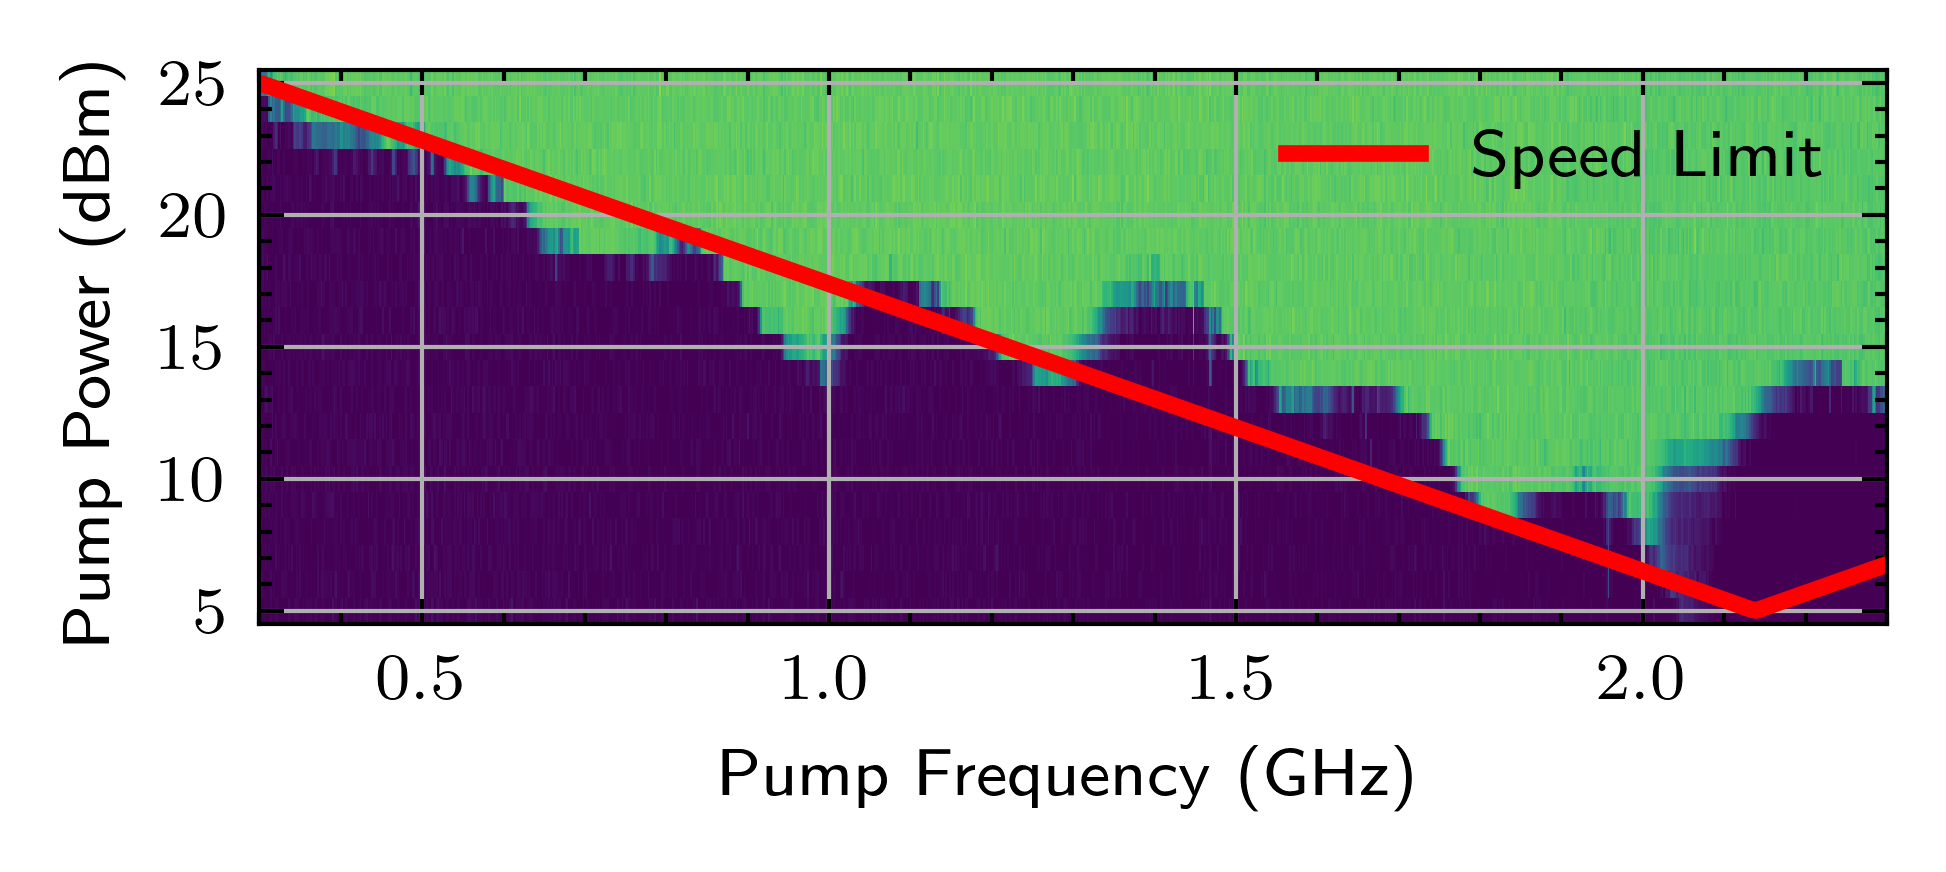

In [170]:
# ================================
# PLOT: Experimental Data with Speed Limit Overlay
# ================================
# Generate x-values over the experimental range (0.3 to 2.3 GHz)
x_vals = np.linspace(f_left, 2.3, 300)
y_vals = compute_snail_aware_max_dBm(x_vals)

with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))
    # Plot the experimental data (convert frequency from Hz to GHz)
    cmesh = ax.pcolormesh(
        freqList / 1e9,
        pwrList,
        glist.T,
        shading="auto",
        cmap="viridis_r",
        vmin=-0.1,
        vmax=0.9,
    )
    ax.set_xlabel("Pump Frequency (GHz)")
    ax.set_ylabel("Pump Power (dBm)")
    ax.set_xticks([0.5, 1, 1.5, 2])
    ax.set_yticks([5, 10, 15, 20, 25])
    # Optionally add a colorbar:
    # fig.colorbar(cmesh, ax=ax, ticks=[0, 1])
    # Overlay the speed limit curve
    ax.plot(x_vals, y_vals, color="red", linewidth=2, label="Speed Limit")
    ax.legend()
    ax.set_xlim(f_left, 2.3)
    ax.grid(True)
    # plt.title("Pump Data with Speed Limit")
plt.show()

Calibration: ε = -6.926e+10 and X_factor = -3.984e+09


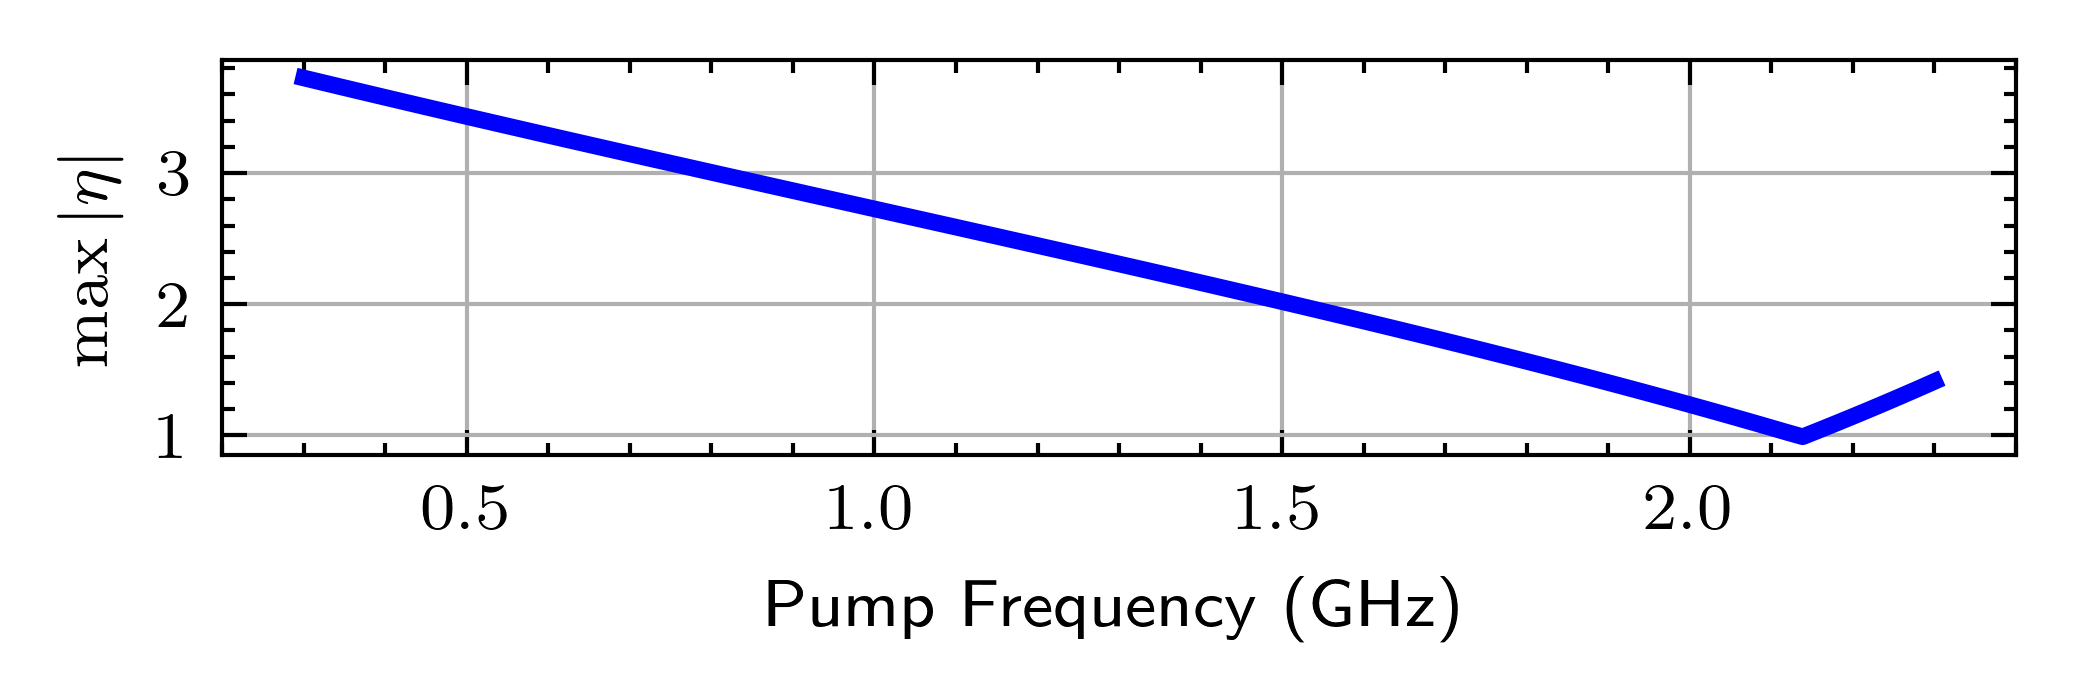

In [180]:
# ================================
# CALIBRATION: Fit the conversion factor from dBm to ε
# ================================
# Calibration: use pump frequency = test_ghz, gate duration = t_f_calib.
w_pump_calib = 2 * np.pi * test_ghz * 1e9
w_snail_calib = 2 * np.pi * f_SNAIL * 1e9
dBm_calib = compute_snail_aware_max_dBm(test_ghz)

epsilon_calib, X_factor = fit_epsilon(
    dBm_calib, t_f_calib, g3, lambdaq, w_pump_calib, w_snail_calib
)
print(f"Calibration: ε = {epsilon_calib:.3e} and X_factor = {X_factor:.3e}")

# ================================
# PLOT: |η| vs. Pump Frequency
# ================================
# Use the same pump frequency range as before.
frequency_range_GHz = np.linspace(0.3, 2.3, 100)
eta_values = []

for f in frequency_range_GHz:
    # Convert pump and SNAIL frequencies to angular frequencies (rad/s)
    w_pump = 2 * np.pi * f * 1e9
    w_snail = 2 * np.pi * f_SNAIL * 1e9

    # Get the maximum allowed pump power (in dBm) for this frequency.
    max_dBm = compute_snail_aware_max_dBm(f)

    # Compute the effective drive amplitude ε using the calibrated conversion factor.
    epsilon = X_factor * max_dBm

    # Calculate η (note: the denominator can be negative, so we take the absolute value later)
    eta_val = epsilon * w_snail / (w_pump**2 - w_snail**2)

    # Append the absolute value of η.
    eta_values.append(np.abs(eta_val))

eta_values = np.array(eta_values)

with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))
    ax.plot(frequency_range_GHz, eta_values, "b-", linewidth=2)
    ax.set_xlabel("Pump Frequency (GHz)")
    ax.set_ylabel(r"$\max{|\eta|}$")
    ax.grid(True)
    plt.tight_layout()
plt.show()

Calibration: ε = -6.926e+10 and X_factor = -3.984e+09


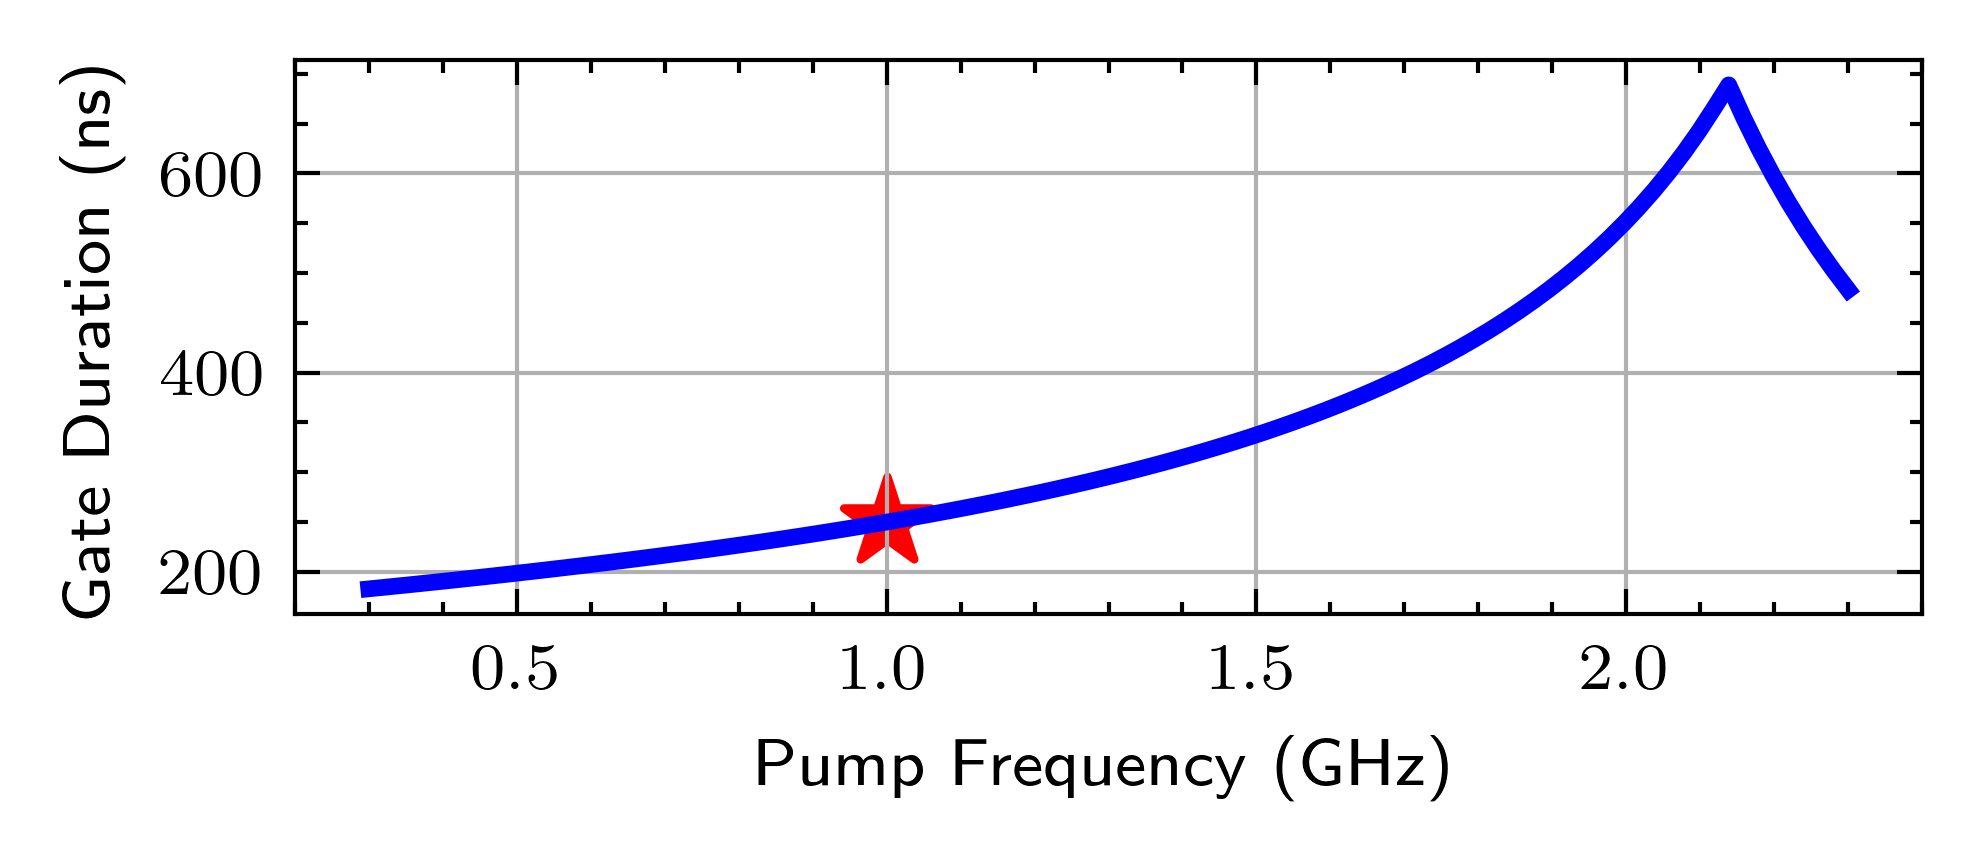

In [178]:
# ================================
# PLOT: Minimum Gate Duration (t_f) vs. Pump Frequency
# ================================
frequency_range_GHz = np.linspace(0.3, 2.3, 100)  # e.g. from 0.5 GHz to 2.0 GHz
gate_durations = np.array(
    [compute_gate_duration(f, X_factor, g3, lambdaq) for f in frequency_range_GHz]
)

with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))
    ax.scatter(test_ghz, t_f_calib * 1e9, marker="*", color="red", s=120, zorder=1)
    ax.plot(frequency_range_GHz, gate_durations * 1e9, "b-", linewidth=2)
    ax.set_xlabel("Pump Frequency (GHz)")
    ax.set_ylabel("Gate Duration (ns)")
    ax.grid(True)
plt.show()

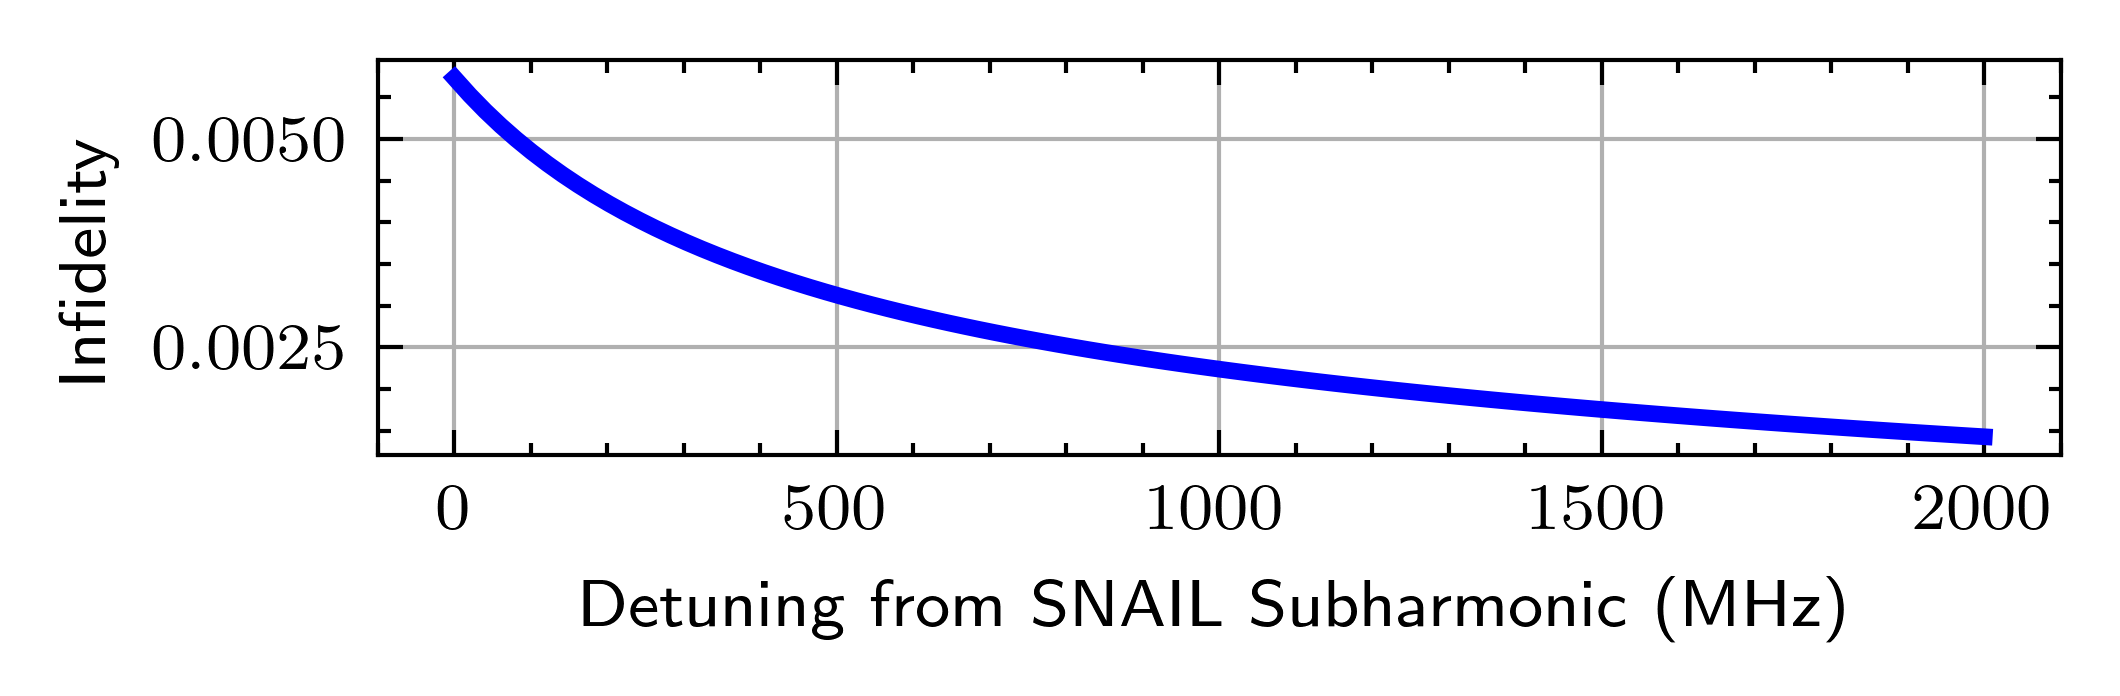

In [173]:
# -------------------------------------------------
# Final Plot: Estimated Infidelity vs. Detuning
# -------------------------------------------------
# We want the detuning axis to go from 0 to 1000 MHz.
# Since detuning (MHz) = (f_pump - f0) * 1e3, choose pump frequencies accordingly.
pump_freq_range = np.linspace(
    f0, f0 - 2, 100
)  # f0 to f0+1 GHz => 0 to 1000 MHz detuning

# Compute the gate durations for each pump frequency using the calibrated X_factor.
gate_durations = np.array(
    [compute_gate_duration(f, X_factor, g3, lambdaq) for f in pump_freq_range]
)

# Estimate the infidelity for each frequency using: infidelity = exp(-t_f/T1)
infidelity = 1 - np.exp(-gate_durations / T1)

# Compute the detuning in MHz:
detuning_MHz = np.abs((pump_freq_range - f0) * 1e3)

# Create the final plot with x-axis from 0 to 1000 MHz.
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots(figsize=(3.5, 1.2))
    ax.plot(detuning_MHz, infidelity, "b-", linewidth=2)
    ax.set_xlabel("Detuning from SNAIL Subharmonic (MHz)")
    ax.set_ylabel("Infidelity")
    # ax.set_xlim(0, 1000)  # x-axis from 0 to 1000 MHz
    ax.grid(True)
    # ax.set_yscale("log")
    plt.tight_layout()
plt.show()

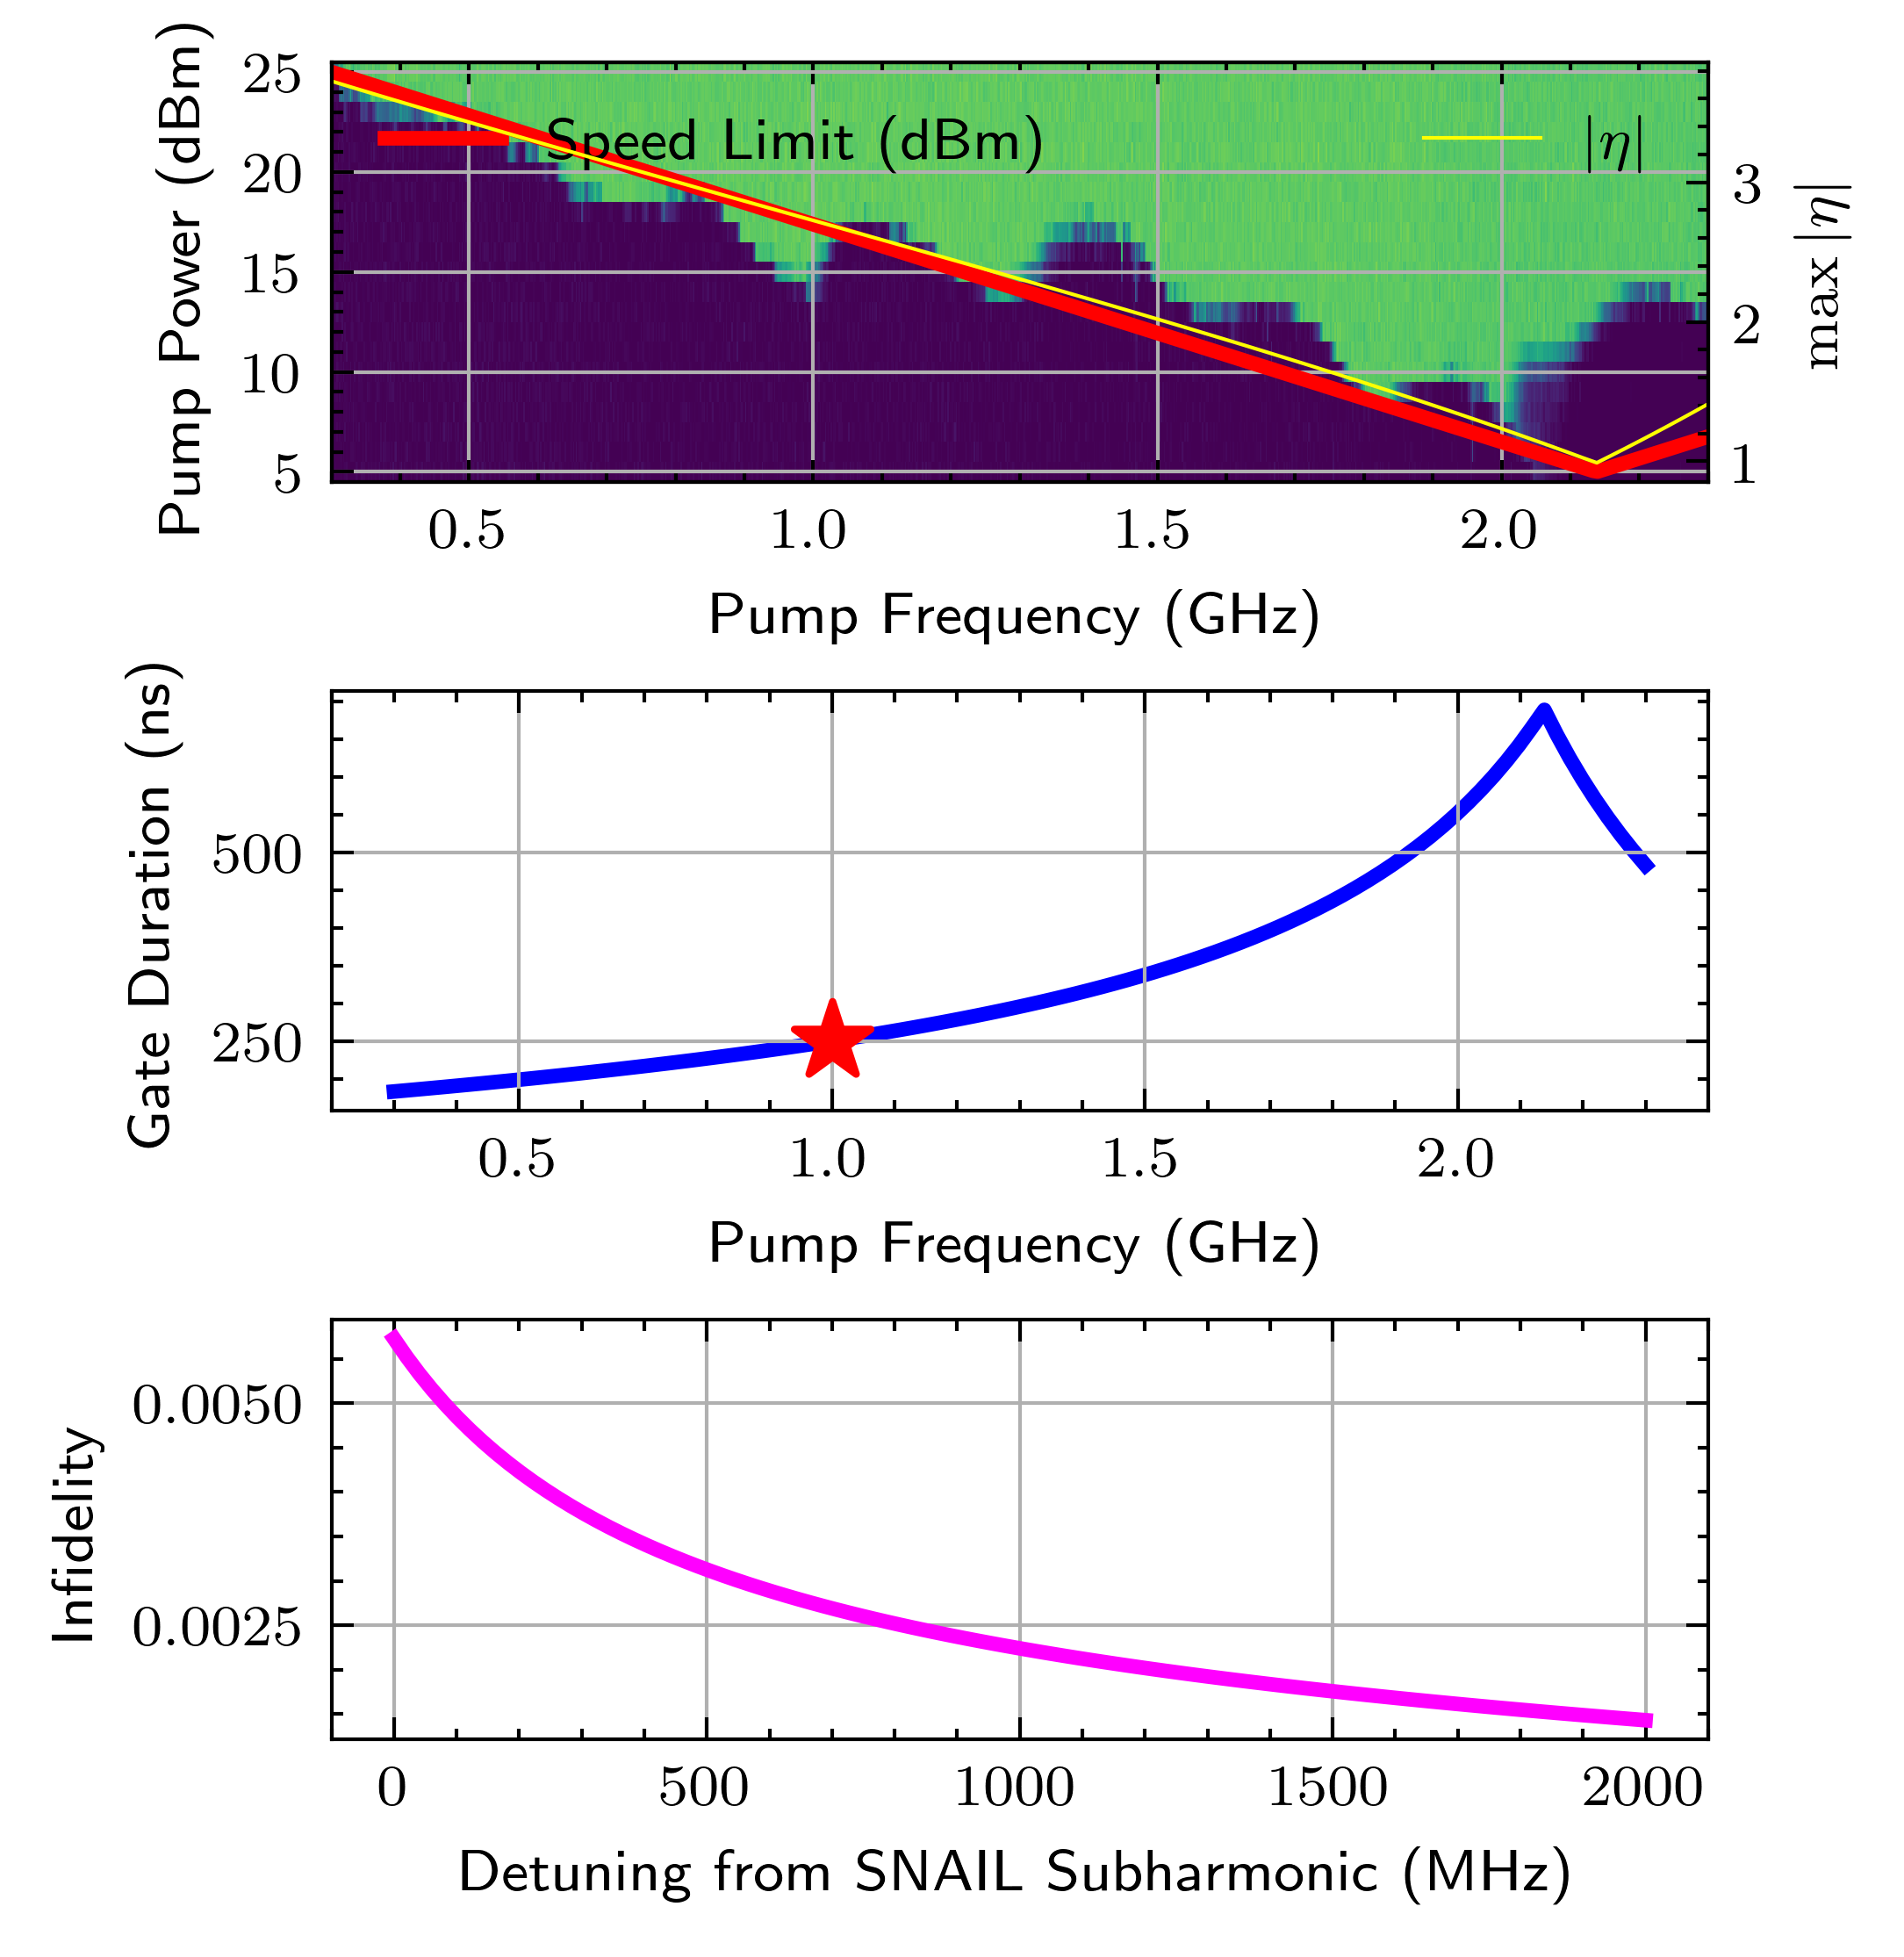

In [202]:
# ---------------------------
# FINAL COMBINED PLOT: Three Vertically Stacked Subplots
# ---------------------------
with plt.style.context(["ieee", "use_mathtext", "science"]):
    # Create 3 subplots, with a total figure height scaled to 3 * 1.2 inches.
    fig, axs = plt.subplots(3, 1, figsize=(3.5, 1.2 * 3), constrained_layout=True)

    # ------------------------------------------------
    # Subplot 1: Experimental Data with Speed Limit and Twin y-axis for |η|
    # ------------------------------------------------
    ax1 = axs[0]
    # Plot experimental data as a pcolormesh (pump frequency in GHz vs. pump power in dBm)
    pcm = ax1.pcolormesh(
        freqList / 1e9,
        pwrList,
        glist.T,
        shading="auto",
        cmap="viridis_r",
        vmin=-0.1,
        vmax=0.9,
    )
    # Plot the speed limit curve (pump power in dBm) on the left y-axis
    ax1.plot(x_vals, y_vals, color="red", linewidth=2, label="Speed Limit (dBm)")
    ax1.set_xlabel("Pump Frequency (GHz)")
    ax1.set_ylabel("Pump Power (dBm)")
    ax1.set_xticks([0.5, 1, 1.5, 2])
    ax1.set_yticks([5, 10, 15, 20, 25])
    ax1.set_xlim(f_left, 2.3)
    ax1.grid(True)
    ax1.legend(loc="upper left")

    # Create a twin y-axis to plot |η| (which is a linear transform of pump power)
    ax1_twin = ax1.twinx()
    ax1_twin.plot(
        frequency_range_GHz,
        eta_values,
        "-",
        color="yellow",
        linewidth=0.5,
        label=r"$|\eta|$",
    )
    ax1_twin.set_ylabel(r"$\max{|\eta|}$")
    ax1_twin.legend(loc="upper right")

    # ------------------------------------------------
    # Subplot 2: Minimum Gate Duration (t_f) vs. Pump Frequency
    # ------------------------------------------------
    ax2 = axs[1]
    # Plot the computed gate durations (converted to ns)
    ax2.plot(
        frequency_range_GHz,
        gate_durations * 1e9,
        "-",
        color="blue",
        linewidth=2,
        zorder=1,
    )
    # Plot the calibration star marker with a high zorder so it appears on top
    ax2.scatter(test_ghz, t_f_calib * 1e9, marker="*", color="red", s=120, zorder=3)
    ax2.set_xlabel("Pump Frequency (GHz)")
    ax2.set_ylabel("Gate Duration (ns)")
    ax2.grid(True)

    # ------------------------------------------------
    # Subplot 3: Estimated Infidelity vs. Detuning (using pink)
    # ------------------------------------------------
    ax3 = axs[2]
    ax3.plot(detuning_MHz, infidelity, "-", color="magenta", linewidth=2)
    ax3.set_xlabel("Detuning from SNAIL Subharmonic (MHz)")
    ax3.set_ylabel("Infidelity")
    ax3.grid(True)

plt.show()